In [2]:
import torch.nn as nn
import torch.nn.functional as F

class simpleconv3(nn.Module):
    def __init__(self):
        super(simpleconv3,self).__init__()
        self.conv1 = nn.Conv2d(3, 12, 3, 2)#1、通道数当前层深度。2、输出深度。3、卷积核大小。4、步长
        self.bn1 = nn.BatchNorm2d(12)
        self.conv2 = nn.Conv2d(12, 24, 3, 2)
        self.bn2 = nn.BatchNorm2d(24)
        self.conv3 = nn.Conv2d(24, 48, 3, 2)
        self.bn3 = nn.BatchNorm2d(48)
        self.fc1 = nn.Linear(48 * 5 * 5 , 1200)
        self.fc2 = nn.Linear(1200 , 128)
        self.fc3 = nn.Linear(128 , 4)

    def forward(self , x):
        x = F.relu(self.bn1(self.conv1(x)))
        #print "bn1 shape",x.shape
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = x.view(-1 , 48 * 5 * 5) 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
#coding:utf8
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
import os
from tensorboardX import SummaryWriter
import torch.nn.functional as F
import numpy as np

import warnings

warnings.filterwarnings('ignore')

writer = SummaryWriter()

def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train(True)  # Set model to training mode
            else:
                model.train(False)  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0.0

            for data in dataloders[phase]:
                inputs, labels = data
                if use_gpu:
                    inputs = Variable(inputs.cuda())
                    labels = Variable(labels.cuda())
                else:
                    inputs, labels = Variable(inputs), Variable(labels)

                optimizer.zero_grad()
                outputs = model(inputs)
                _, preds = torch.max(outputs.data, 1)
                loss = criterion(outputs, labels)
                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.data.item()
                running_corrects += torch.sum(preds == labels).item()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects / dataset_sizes[phase]
           
            if phase == 'train':
                writer.add_scalar('data/trainloss', epoch_loss, epoch)
                writer.add_scalar('data/trainacc', epoch_acc, epoch)
            else:
                writer.add_scalar('data/valloss', epoch_loss, epoch)
                writer.add_scalar('data/valacc', epoch_acc, epoch)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

    writer.export_scalars_to_json("./all_scalars.json")
    writer.close()
    return model

if __name__ == '__main__':

    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomSizedCrop(48),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ]),
        'val': transforms.Compose([
            transforms.Scale(64),
            transforms.CenterCrop(48),
            transforms.ToTensor(),
            transforms.Normalize([0.5,0.5,0.5], [0.5,0.5,0.5])
        ]),
    }

    data_dir = './Emotion_Recognition_File/train_val_data/' # 数据集所在的位置
    image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                              data_transforms[x]) for x in ['train', 'val']}
    dataloders = {x: torch.utils.data.DataLoader(image_datasets[x],
                                                 batch_size=64,
                                                 shuffle=True if x=="train" else False,
                                                 num_workers=8) for x in ['train', 'val']}

    dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

    use_gpu = torch.cuda.is_available()
    print("是否使用 GPU", use_gpu)
    modelclc = simpleconv3()
    print(modelclc)
    if use_gpu:
        modelclc = modelclc.cuda()

    criterion = nn.CrossEntropyLoss()
    optimizer_ft = optim.SGD(modelclc.parameters(), lr=0.1, momentum=0.9)
    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=100, gamma=0.1)

    modelclc = train_model(model=modelclc,
                           criterion=criterion,
                           optimizer=optimizer_ft,
                           scheduler=exp_lr_scheduler,
                           num_epochs=10)  # 这里可以调节训练的轮次
    if not os.path.exists("models"):
        os.mkdir('models')
    torch.save(modelclc.state_dict(),'models/model.ckpt')

tensor([[8.1330e-03, 6.7033e-04, 9.8497e-01, 6.2311e-03]],
       grad_fn=<SoftmaxBackward>)


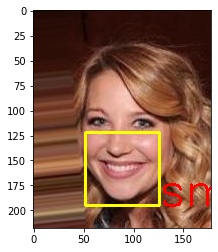

tensor([[1.0822e-06, 1.9005e-09, 1.0000e+00, 2.3623e-07]],
       grad_fn=<SoftmaxBackward>)


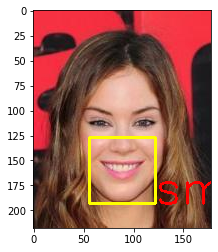

tensor([[9.9190e-01, 3.7207e-03, 4.3589e-03, 1.5936e-05]],
       grad_fn=<SoftmaxBackward>)


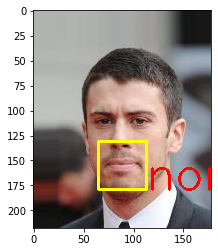

tensor([[4.3434e-07, 1.2525e-06, 1.1251e-05, 9.9999e-01]],
       grad_fn=<SoftmaxBackward>)


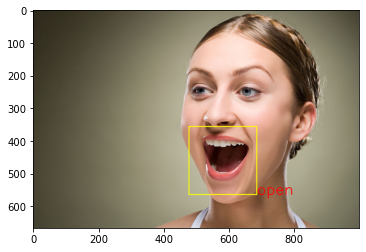

tensor([[0.0899, 0.8970, 0.0115, 0.0016]], grad_fn=<SoftmaxBackward>)


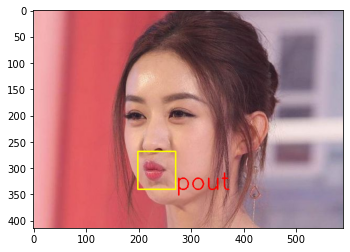

In [3]:
# coding:utf8

import sys
import numpy as np
import cv2
import os
import dlib

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import torchvision
from torchvision import datasets, models, transforms
import time
from PIL import Image
import torch.nn.functional as F

import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')


PREDICTOR_PATH = "./Emotion_Recognition_File/face_detect_model/shape_predictor_68_face_landmarks.dat"
predictor = dlib.shape_predictor(PREDICTOR_PATH)
cascade_path = './Emotion_Recognition_File/face_detect_model/haarcascade_frontalface_default.xml'
cascade = cv2.CascadeClassifier(cascade_path)

if not os.path.exists("results"):
    os.mkdir("results")
    

def standardization(data):
    mu = np.mean(data, axis=0)
    sigma = np.std(data, axis=0)
    return (data - mu) / sigma


def get_landmarks(im):
    rects = cascade.detectMultiScale(im, 1.3, 5)
    x, y, w, h = rects[0]
    rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
    return np.matrix([[p.x, p.y] for p in predictor(im, rect).parts()])


def annotate_landmarks(im, landmarks):
    im = im.copy()
    for idx, point in enumerate(landmarks):
        pos = (point[0, 0], point[0, 1])
        cv2.putText(im,
                    str(idx),
                    pos,
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=0.4,
                    color=(0, 0, 255))
        cv2.circle(im, pos, 3, color=(0, 255, 255))
    return im


testsize = 48  # 测试图大小

data_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])
net = simpleconv3()
net.eval()
modelpath = "./models/model.ckpt"  # 模型路径
net.load_state_dict(
    torch.load(modelpath, map_location=lambda storage, loc: storage))

# 一次测试一个文件
img_path = "./Emotion_Recognition_File/find_face_img/"
imagepaths = os.listdir(img_path)  # 图像文件夹
for imagepath in imagepaths:
    im = cv2.imread(os.path.join(img_path, imagepath), 1)
    try:
        rects = cascade.detectMultiScale(im, 1.3, 5)
        x, y, w, h = rects[0]
        rect = dlib.rectangle(int(x), int(y), int(x + w), int(y + h))
        landmarks = np.matrix([[p.x, p.y]
                               for p in predictor(im, rect).parts()])
    except:
#         print("没有检测到人脸")
        continue  # 没有检测到人脸

    xmin = 10000
    xmax = 0
    ymin = 10000
    ymax = 0

    for i in range(48, 67):
        x = landmarks[i, 0]
        y = landmarks[i, 1]
        if x < xmin:
            xmin = x
        if x > xmax:
            xmax = x
        if y < ymin:
            ymin = y
        if y > ymax:
            ymax = y

    roiwidth = xmax - xmin
    roiheight = ymax - ymin

    roi = im[ymin:ymax, xmin:xmax, 0:3]

    if roiwidth > roiheight:
        dstlen = 1.5 * roiwidth
    else:
        dstlen = 1.5 * roiheight

    diff_xlen = dstlen - roiwidth
    diff_ylen = dstlen - roiheight

    newx = xmin
    newy = ymin

    imagerows, imagecols, channel = im.shape
    if newx >= diff_xlen / 2 and newx + roiwidth + diff_xlen / 2 < imagecols:
        newx = newx - diff_xlen / 2
    elif newx < diff_xlen / 2:
        newx = 0
    else:
        newx = imagecols - dstlen

    if newy >= diff_ylen / 2 and newy + roiheight + diff_ylen / 2 < imagerows:
        newy = newy - diff_ylen / 2
    elif newy < diff_ylen / 2:
        newy = 0
    else:
        newy = imagerows - dstlen

    roi = im[int(newy):int(newy + dstlen), int(newx):int(newx + dstlen), 0:3]
    roi = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)
    roiresized = cv2.resize(roi,
                            (testsize, testsize)).astype(np.float32) / 255.0
    imgblob = data_transforms(roiresized).unsqueeze(0)
    imgblob.requires_grad = False
    imgblob = Variable(imgblob)
    torch.no_grad()
    predict = F.softmax(net(imgblob))
    print(predict)
    index = np.argmax(predict.detach().numpy())

    im_show = cv2.imread(os.path.join(img_path, imagepath), 1)
    im_h, im_w, im_c = im_show.shape
    pos_x = int(newx + dstlen)
    pos_y = int(newy + dstlen)
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(im_show, (int(newx), int(newy)),
                  (int(newx + dstlen), int(newy + dstlen)), (0, 255, 255), 2)
    if index == 0:
        cv2.putText(im_show, 'none', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
    if index == 1:
        cv2.putText(im_show, 'pout', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
    if index == 2:
        cv2.putText(im_show, 'smile', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
    if index == 3:
        cv2.putText(im_show, 'open', (pos_x, pos_y), font, 1.5, (0, 0, 255), 2)
#     cv2.namedWindow('result', 0)
#     cv2.imshow('result', im_show)
    cv2.imwrite(os.path.join('results', imagepath), im_show)
#     print(os.path.join('results', imagepath))
    plt.imshow(im_show[:, :, ::-1])  # 这里需要交换通道，因为 matplotlib 保存图片的通道顺序是 RGB，而在 OpenCV 中是 BGR
    plt.show()
#     cv2.waitKey(0)
# cv2.destroyAllWindows()

> 再次说明：0 代表 none、 1 代表pouting、2 代表 smile、3 代表 openmouth

> 上面展示的图片上方会有一个输出，如：tensor([[8.1330e-03, 6.7033e-04, 9.8497e-01, 6.2311e-03]])

> 这个代表的含义是，该图片在这个模型预测下，是该类别的可能性，比如上面这个例子 `9.8497e-01` 是四个值最大的，它的索引是 2（从 0 开始算），所以预测该图片为 `smile`
